# Multiobjective Optimization

This section provides code implementations for the concepts covered in class for multiobjective optimization. Multiobjective optimization provides methods to solve optimization problems with multiple competing objectives. The application of these methods to simple analytical examples is also provided in this section. The multiobjective methods used in class and in this section of the Jupyter book are based on differential evolution (DE) covered earlier in the class. This section has the following two subsections:

1. Multiobjective optimization using differential evolution
2. Surrogate-based multiobjective optimization

The code blocks below introduce the multiobjective optimization examples used in this section. The next code block imports the required packages for this section. 

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from smt.sampling_methods import LHS
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import pymoo.gradient.toolbox as anp
from pymoo.core.problem import Problem

## Branin-Currin optimization problem

The first example used in this section is an unconstrained multiobjective problem with two design variables and two objective functions. The two functions are the rescaled Branin function and the Currin function. The optimization problem statement is given as

$$
    \begin{gathered}
    \min f(\textbf{x}) = \begin{cases} f_1(\textbf{x}) = \frac{1}{51.95}(( \bar{x_2} - \frac{5.1}{4\pi^2} \bar{x_1}^2 + \frac{5}{\pi}\bar{x_1} - 6 )^2 + 10 ( 1-\frac{1}{8\pi} )\cos \bar{x_1} - 44.81) \\ \\ f_2(\textbf{x}) = [1-\exp(\frac{-1}{2x_2})]\frac{2300x_1^3+1900x_1^2+2092x_1+60}{100x_1^3+500x_1^2+4x_1+20} \end{cases} \\
    0.0 \leq x_1, x_2 \leq 1.0 \\
    \text{where} \quad \bar{x_1} = 15x_1 - 5, \bar{x_2} = 15x_2
    \end{gathered}
$$

The block of code below defines the two functions. 

In [132]:
# Defining the objective functions
def branin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = 15*x[:,0] - 5
    x2 = 15*x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (1/51.95)*((x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 - 44.81)

    if dim == 1:
        y = y.reshape(-1)

    return y

def currin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    factor = 1 - np.exp(-1/(2*x2))
    num = 2300*x1**3 + 1900*x1**2 + 2092*x1 + 60
    den = 100*x1**3 + 500*x1**2 + 4*x1 + 20
    y = factor*num/den
    
    if dim == 1:
        y = y.reshape(-1)

    return y

The next few code blocks will locate the Pareto front for the problem and plot the Pareto front in the objective space. The code block uses the non-dominated sorting algorithm of `pymoo` to find the non-dominated points in the objective space. The non-dominated points represent the Pareto front of the problem. The non-dominated sorting algorithm may not always perfectly provide all of the non-dominated points of the problem and it is a good idea to make sure that all the points provided are actually non-dominated solutions. It is also sometimes necessary to adjust the parameter `n_stop_if_ranked` which indicates approximately how many points should survive in the initial population of points at the end of the sorting algorithm. Raising or lowering this value can improve the representation of the Pareto front.

In [133]:
# Generating a grid of points
num_points = 100

# Defining x and y values
x = np.linspace(1e-6,1,num_points)
y = np.linspace(1e-6,1,num_points)

# Creating a mesh
X, Y = np.meshgrid(x, y)

# Finding the front through non-dominated sorting
z1 = branin(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
z2 =  currin(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
nds = NonDominatedSorting()
F = np.column_stack((z1,z2))
pareto = nds.do(F, n_stop_if_ranked=50)

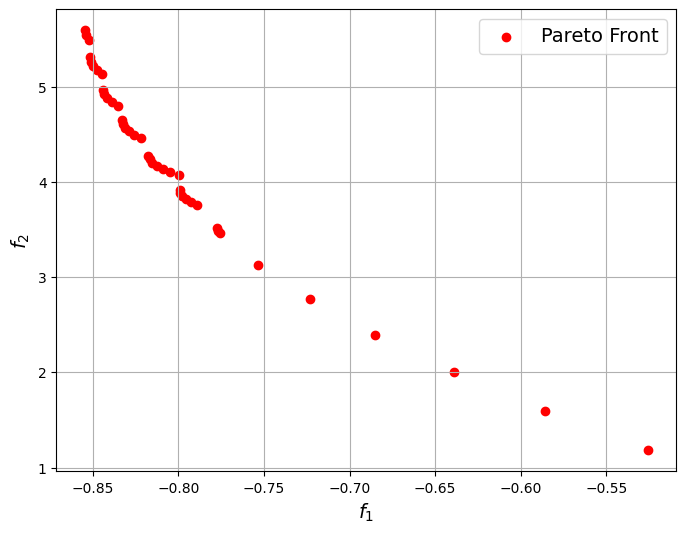

In [134]:
# Plotting the non-dominated solutions 
Z_pareto = F[pareto[0]]
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Z_pareto[1:,0], Z_pareto[1:,1], color="red", label="Pareto Front")
ax.set_xlabel("$f_1$", fontsize=14)
ax.set_ylabel("$f_2$", fontsize=14)
ax.grid()
ax.legend(loc="upper right", fontsize = 14)

The above plot shows the non-dominated solutions of the problem in the objective space. The curve passing through these points is the Pareto front of the problem. The Pareto front is convex in shape for this problem.

## Constrained CTP1 optimization problem

The second example used in this section is a constrained multiobjective problem with two design variables, two objective functions and two constraints. This optimization problem is from the CTP suite of test functions for multiobjective design. The optimization problem statement is given as

$$
    \begin{gathered}
    \min f(\textbf{x}) = \begin{cases} f_1(\textbf{x}) = x_1 \\ f_2(\textbf{x}) = (1+x_2)\exp(-\frac{x_1}{1+x_2}) \end{cases} \\
    \textrm{subject to} \quad g_1(\textbf{x}) = 1 - \frac{f_2(\textbf{x})}{0.858\exp(-0.541f_1(\textbf{x}))} \leq 0\\
    g_2(\textbf{x}) = 1 - \frac{f_2(\textbf{x})}{0.728\exp(-0.295f_1(\textbf{x}))} \leq 0\\
    0 \leq x_1,x_2 \leq 1\\
    \end{gathered}
$$

The block of code below defines the objective and constraint functions for the problem.  

In [135]:
# Defining the objective functions
def f1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = x[:,0]
    return y
    
def f2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]

    y = (1+x2)*np.exp(-x1/(1+x2))

    return y

def g1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    F1 = f1(x)
    F2 = f2(x)
    
    g = 1 - F2/(0.858*np.exp(-0.541*F1))

    return g

def g2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    F1 = f1(x)
    F2 = f2(x)
    
    g = 1 - F2/(0.728*np.exp(-0.295*F1))

    return g
    

The code block below uses the non-dominated sorting algorithm of `pymoo` to find the non-dominated points in the objective space. The non-dominated points represent the Pareto front of the problem.

In [153]:
# Generating an LHS sample plan
sampler = LHS(xlimits=np.array( [[1e-6, 1.0], [1e-6, 1.0]] ), criterion='ese')

# Training data
num_sample = 1000 # Sampling a high number of points to make the process more accurate
X = sampler(num_sample)

# Evaluating the function values at meshpoints
z1 = f1(X)
z2 = f2(X)
const1 = g1(X)
const2 = g2(X)

z1 = z1[(const1<0) & (const2<0)]
z2 = z2[(const1<0) & (const2<0)]
F = np.column_stack((z1,z2))
pareto = nds.do(F, n_stop_if_ranked=800)
Z_pareto = F[pareto[1]]

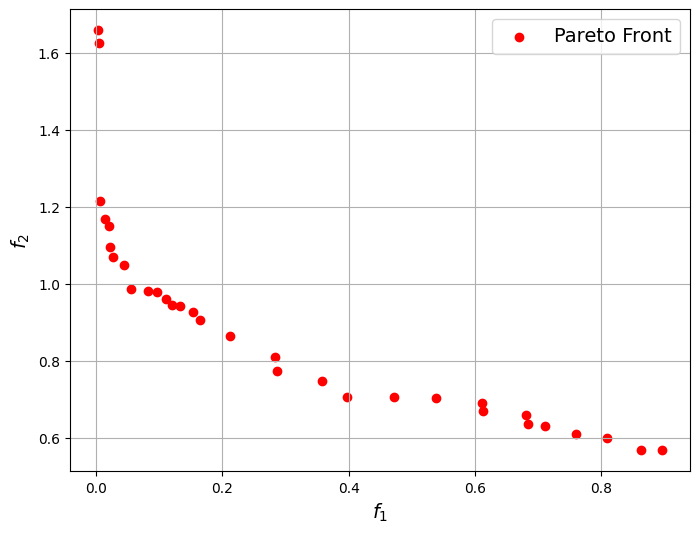

In [155]:
# Plotting the contours
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Z_pareto[:,0], Z_pareto[:,1], color="red", label="Pareto Front")
ax.set_xlabel("$f_1$", fontsize=14)
ax.set_ylabel("$f_2$", fontsize=14)
ax.grid()
ax.legend(loc="upper right", fontsize = 14)

The Pareto front for the 2D truss optimization problem is as shown above in the plot. The Pareto front for this problem is also convex.

## Constrained TNK optimization problem

The third and final example is another analytical multiobjective optimization problem. The suite of test functions are derived from a set of local adjustment and distance functions. The problem has two design variables, two objective functions and two constraints. Intrestingly, the two objective functions in this case are the two design variables themselves. The optimization problem statement is given as

$$
    \begin{gathered}
    \min f(\textbf{x}) = \begin{cases} f_1(\textbf{x}) = x_1 \\ f_2(\textbf{x}) = x_2 \end{cases} \\
    \textrm{subject to} \quad g_1(\textbf{x}) = -(x_1^2 + x_2^2) - 1 - 0.1\cos(16\arctan(\frac{x_1}{x_2})) \leq 0 \\
    g_2(\textbf{x}) = (x_1-0.5)^2 + (x_2-0.5)^2 - 0.5 \leq 0\\
    0.0 \leq x_1,x_2 \leq 1.0
    \end{gathered}
$$

The block of code below defines the objective and constraint functions for the problem. The code is adapted from the `pymoo` source code on GitHub.

In [122]:
# Defining the objective functions
def f1(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
        
    y = x[:,0]
    
    return y

def f2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
        
    y = x[:,1]
    
    return y

# Defining the constraints
def g1(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
        
    g = -(np.square(x[:, 0]) + np.square(x[:, 1]) - 1.0 - 0.1 * np.cos(16.0 * np.arctan(x[:, 0] / x[:, 1])))
    
    return g

def g2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
        
    g =  2 * (anp.square(x[:, 0] - 0.5) + anp.square(x[:, 1] - 0.5)) - 1

    return g

The block of code below will locate the Pareto front of the problem using the non-dominated sorting algorithm as done for the previous examples.

In [123]:
# To accurately find the Pareto front through non-dominated sorting a LHS sampling will be used
# The Pareto front of this problem has an interesting shape
# Generating an LHS sample plan
sampler = LHS(xlimits=np.array( [[1e-6, 1.0], [1e-6, 1.0]] ), criterion='ese')

# Training data
num_sample = 10000 # Sampling a high number of points to make the process more accurate
X = sampler(num_sample)

# Evaluating the function values at meshpoints
z1 = f1(X)
z2 = f2(X)
const1 = g1(X)
const2 = g2(X)

z1 = z1[(const1<0) & (const2<0)]
z2 = z2[(const1<0) & (const2<0)]
F = np.column_stack((z1,z2))
pareto = nds.do(F, n_stop_if_ranked=5000)
Z_pareto = F[pareto[0]]

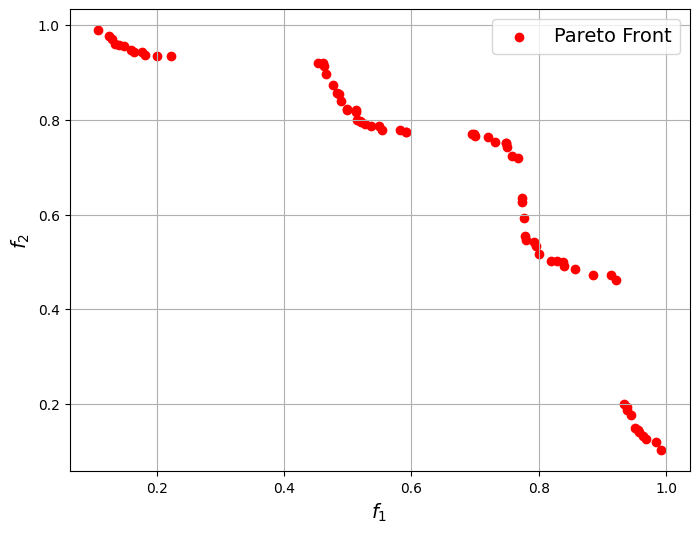

In [124]:
# Plotting the contours
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Z_pareto[:,0], Z_pareto[:,1], color="red", label="Pareto Front")
ax.set_xlabel("$f_1$", fontsize=14)
ax.set_ylabel("$f_2$", fontsize=14)
ax.grid()
ax.legend(loc="upper right", fontsize = 14)

The above plot shows the Pareto front for the TNK optimization problem that is found through non-dominated sorting. The Pareto front for this problem is complex and therefore, the non-dominated sorting algorithm required a large number of LHS samples to find a good representation of the front. The front has both convex and concave regions and also has discontinuities. The non-dominated sorting method is an inefficient way to find the Pareto front for this problem as it requires a large number of sampling points. In the next section, the non-dominated sorting differential evolution (NSDE) algorithm will be used to find the Pareto front.  